<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/%EC%83%88%EB%A1%9C%EC%9A%B4%20%EA%B0%80%EC%A0%95_0209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 새로운 가정
+ feature의 importance 는 p(y|x)의 관계이지, p(x)와는 독립적이다.
+ 맞다. 그러나, DNA철학(?) 즉, 미래(성장?)의 내용이 DNA에 들어 있듯이, 특정 기간의 p(y|x) 내부에는 이후의 p(y|x) 변화를 감지할 수 있는 정보가 들어있지 않을까?
+ 즉, y를 모르는 unsupervised 상태에서 p(x) [ 사실은 p(y'|x) ] 를 가지고 feature의 importance 변화를 감지 할 수 있지 않겠는가???  

In [1]:
if True:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [14]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]   
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)
    
    #if ks_stat == minS:
    #    ks_stat = -ks_stat
    
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [17]:


from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
     
COLUMNS = ['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9']     

## concept drift의 case #2

Concept(Rule)의 변화 : X<br>
Importance의 변화 : O<br>
Drift의 변화 : X<br>

In [85]:
import random

seed_everything(seed=49)

data_x = {}
weight = {}
errors = []
# 난수의 평균
means = [1,1,1,1,1,1,1,1,1,1]
# 난수의 표준편차
stds1 =  [1,1,1,1,1,1,1,1,1,1]
# feature의 가중치
wss1 =   [5,4,3,2,1,0,0,0,0,0]
wss2 =   [0,0,0,0,0,1,2,3,4,5]
# drift가 발생하는 feature
drift_feature = [1,1,-1,1,1,0,-1,1,0,1]
for f in range(10):
    data_x[f'x{f}'] = []
    weight[f'w{f}'] = []
    for i in range(1000):
        for j in range(10):
            data_x[f'x{f}'].extend(means[f] - np.abs(np.random.normal(0,stds1[f]*0.1,10)))  
            '''
            if i < 500:
                #data_x[f'x{f}'].extend(means[f] - np.abs(np.random.normal(0,stds1[f]*0.1 + (i*0.0001),10)))
                weight[f'w{f}'].extend(wss1[f]+ np.random.normal(0.0,0.01,10))   
            else:
                #data_x[f'x{f}'].extend(means[f] - np.abs(np.random.normal(0,stds2[f]*0.1 + (i*0.0001),10)))
                weight[f'w{f}'].extend(wss2[f]+ np.random.normal(0.0,0.01,10))      
            '''
            ww = i/1000
            weight[f'w{f}'].extend((wss1[f]*(1-ww) + wss2[f]*ww) + np.random.normal(0.0,0.01,10))                          


for i in range(10000):        
    errors.extend(np.random.normal(1.0,0.005,10))

dataset = pd.DataFrame(data_x)
importance = pd.DataFrame(weight)

y=np.sum(np.multiply(importance.values,dataset.values),axis=1) + np.asarray(errors)

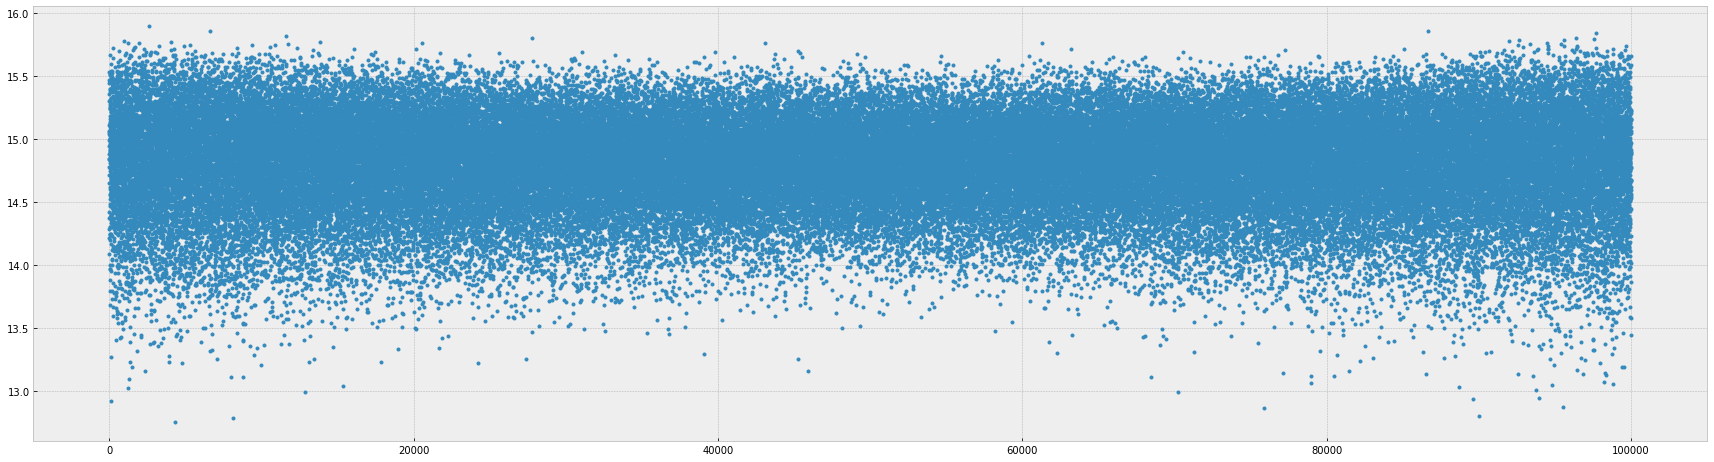

In [86]:
plt.figure(figsize=(30,8))
plt.plot(y,'.')

In [102]:
mn = np.mean(y[0:1000])
print("Y mean:",mn)
dataset['y'] = [1 if i > mn else 0 for i in y]
dataset

Y mean: 14.80917089258472


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,0.895684,0.792031,0.940057,0.812780,0.959240,0.746932,0.949380,0.978290,0.972478,0.929717,0
1,0.917914,0.858407,0.996082,0.952297,0.941283,0.945107,0.921507,0.833492,0.975585,0.956110,1
2,0.933485,0.998429,0.970274,0.958623,0.912402,0.915149,0.894663,0.982727,0.959104,0.828651,1
3,0.817737,0.884680,0.950692,0.893894,0.991393,0.901659,0.889030,0.997981,0.860043,0.975888,0
4,0.855842,0.811231,0.994532,0.880043,0.961054,0.867799,0.791962,0.943408,0.943762,0.905676,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,0.831078,0.915368,0.853795,0.985508,0.946783,0.966766,0.860917,0.919929,0.832203,0.958331,0
99996,0.815569,0.942034,0.973519,0.905562,0.868095,0.770885,0.925595,0.917272,0.893178,0.938779,0
99997,0.878618,0.910226,0.979120,0.804410,0.882451,0.840965,0.918705,0.883398,0.780469,0.825663,0
99998,0.888097,0.950244,0.943173,0.949760,0.982444,0.922953,0.973099,0.980597,0.983211,0.970961,1


In [103]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

trainset = dataset[0:1000].drop(columns=['y']).values
train_y = dataset[0:1000]['y'].values
business_model = RandomForestClassifier(n_estimators=80,max_depth=5)
business_model.fit(trainset,train_y)
testset = dataset[1000:1400].drop(columns=['y']).values
test_y = dataset[1000:1400]['y'].values
base_score = precision_recall_fscore_support(test_y, business_model.predict(testset),average='binary')
base_score

(0.9023255813953488, 0.919431279620853, 0.9107981220657277, None)

## 여기서 sub_model을 만든다.... 

In [104]:
# train_dataset의 50%로 만든다.
sub_trainset = trainset[500:]
sub_train_y = train_y[500:]

sub_business_model = RandomForestClassifier(n_estimators=80,max_depth=5)
sub_business_model.fit(sub_trainset,sub_train_y)
base_score = precision_recall_fscore_support(test_y, sub_business_model.predict(testset),average='binary')
base_score

(0.9158415841584159, 0.8767772511848341, 0.8958837772397095, None)

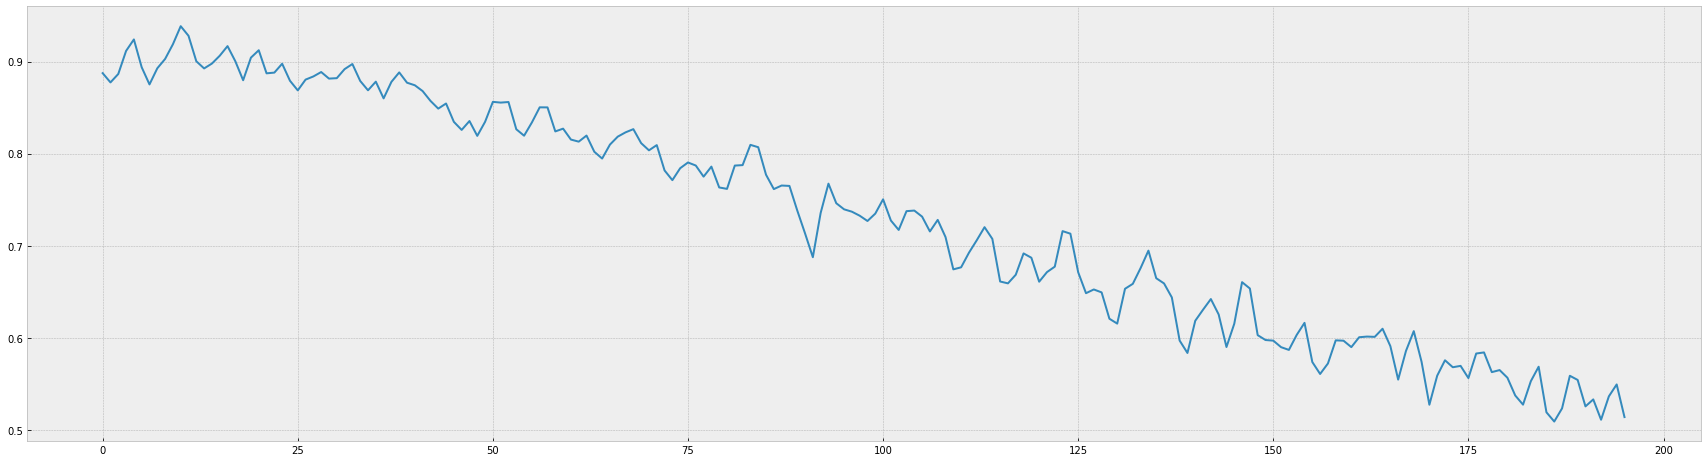

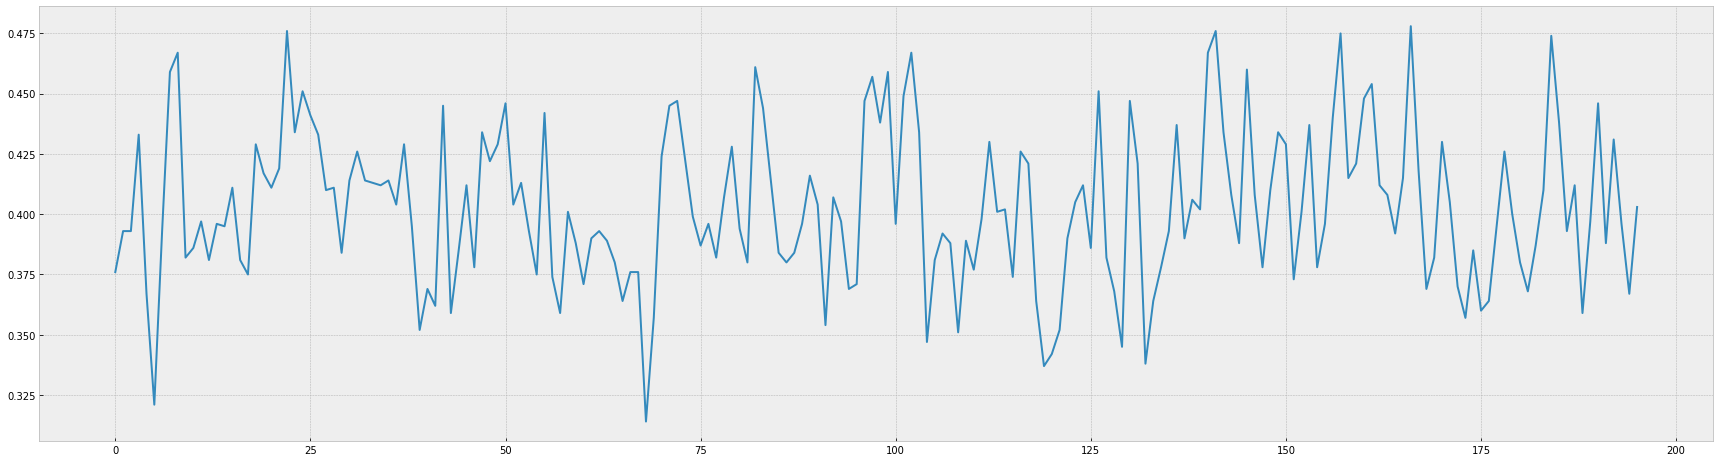

In [105]:
import math

X2 = dataset[1400:].drop(columns=['y']).values
Y2 = dataset[1400:]['y'].values

result = {}
result['precision'] = []
result['predicted'] = []
result['drift'] = []
window_size = 1000
step = 500
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    f1 = precision_recall_fscore_support(uy, business_model.predict(ux),average='binary')
    drift = __ks_drift(trainset,ux)
    result['precision'].append(f1[0])
    result['predicted'].append(0.0)
    result['drift'].append(sum(abs(drift[:,0])))

result_df = pd.DataFrame(result)
result_df['precision'].plot(figsize=(30,8))
plt.show()
result_df['drift'].plot(figsize=(30,8))
plt.show()
     

In [120]:
np.zeros((1,10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [121]:
import math
from scipy.special import rel_entr

result = {}
result['precision'] = []
#result['sub_precision'] = []
result['y_-y__'] = []
result['drift'] = []

drifts = {}
for f in range(10):
    drifts[f'x{f}'] = []

#MI
mi_scores = make_mi_scores(pd.DataFrame(trainset,columns=COLUMNS), train_y, discrete_features="auto")
print(mi_scores.values.reshape(1,-1))
imp_df_mi = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
imp_df_mi2 = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
imp_df_mi3 = pd.DataFrame(np.zeros((1,10)),columns=list(mi_scores.keys()))[COLUMNS]
window_size = 1000
step = 500
predicted = 0
batch = math.ceil((X2.shape[0]-window_size)/step)
for i in range(batch):
    ux = X2[i*step:i*step+window_size]
    uy = Y2[i*step:i*step+window_size]
    y_ = business_model.predict(ux)
    y__ = sub_business_model.predict(ux[500:])
    f1 = precision_recall_fscore_support(uy,y_ ,average='binary')
    #f1_ = precision_recall_fscore_support(uy[0:500],y__ ,average='binary')
    drift = __ks_drift(trainset,ux)
    result['precision'].append(f1[0])
    #result['sub_precision'].append(f1_[0])
    ## KL divergence 
    result['y_-y__'].append(np.std(y_) - np.std(y__))
    result['drift'].append(sum(abs(drift[:,0])))
    for idx, dv in enumerate(drift[:,0]):
        drifts[f'x{idx}'].append(dv)    
            
    #MI
    mi_scores = make_mi_scores(pd.DataFrame(ux,columns=COLUMNS), uy, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi.loc[len(imp_df_mi)] = tmp_df.values.reshape(-1,)

    #PMI
    mi_scores = make_mi_scores(pd.DataFrame(ux,columns=COLUMNS), y_, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi2.loc[len(imp_df_mi2)] = tmp_df.values.reshape(-1,)

    #SPMI
    mi_scores = make_mi_scores(pd.DataFrame(ux[500:],columns=COLUMNS), y__, discrete_features="auto")
    tmp_df = pd.DataFrame(mi_scores.values.reshape(1,-1),columns=list(mi_scores.keys()))[COLUMNS]
    imp_df_mi3.loc[len(imp_df_mi3)] = tmp_df.values.reshape(-1,)
    
    print(f"\r{i+1}/{batch} f1:{f1[0]:.4f}", end="", flush=True)


[[0.1406872  0.11866487 0.03794045 0.03385384 0.01580752 0.00986232
  0.0044504  0.         0.         0.        ]]
196/196 f1:0.5140

[]

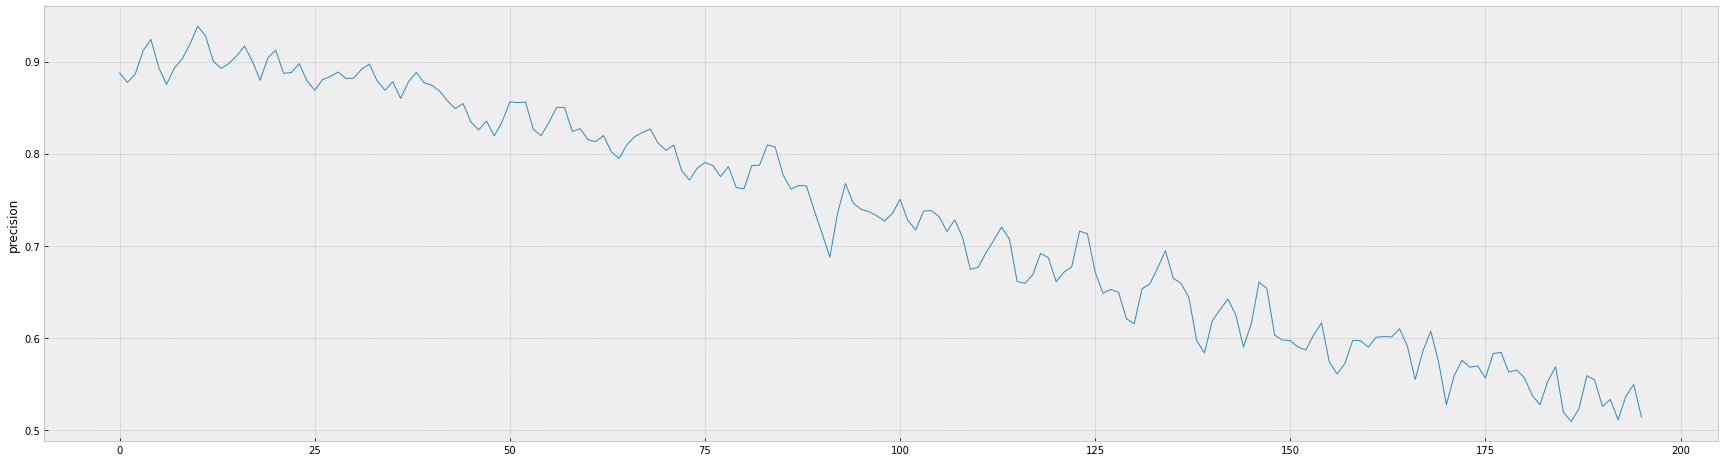

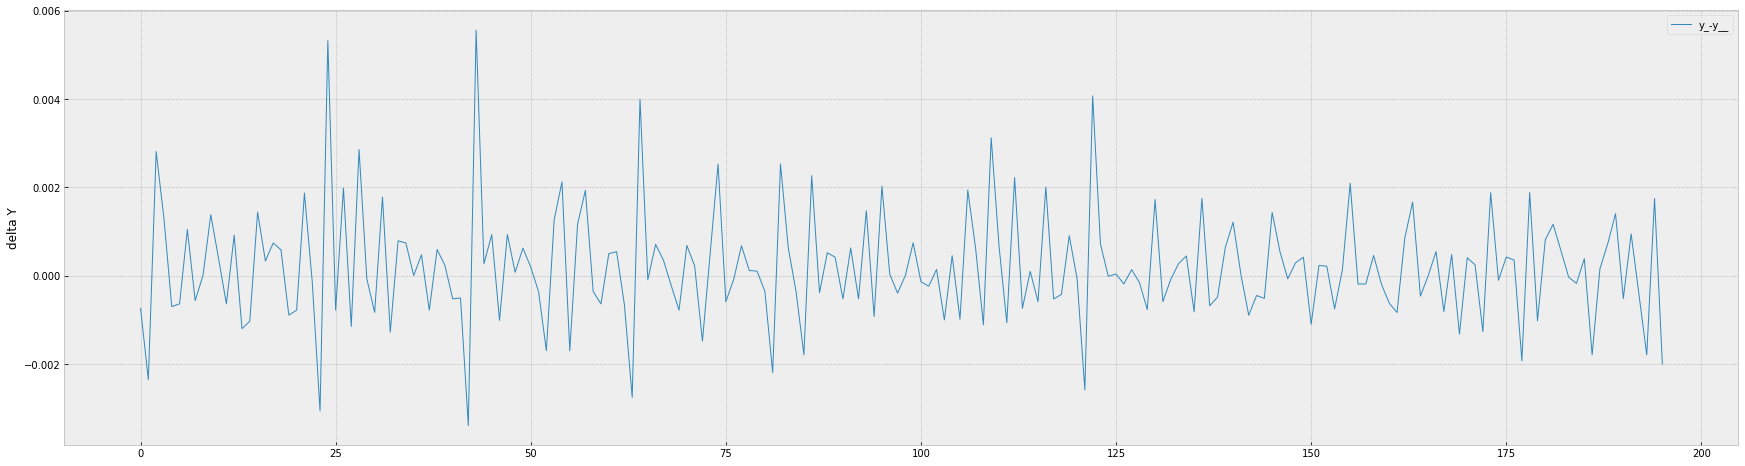

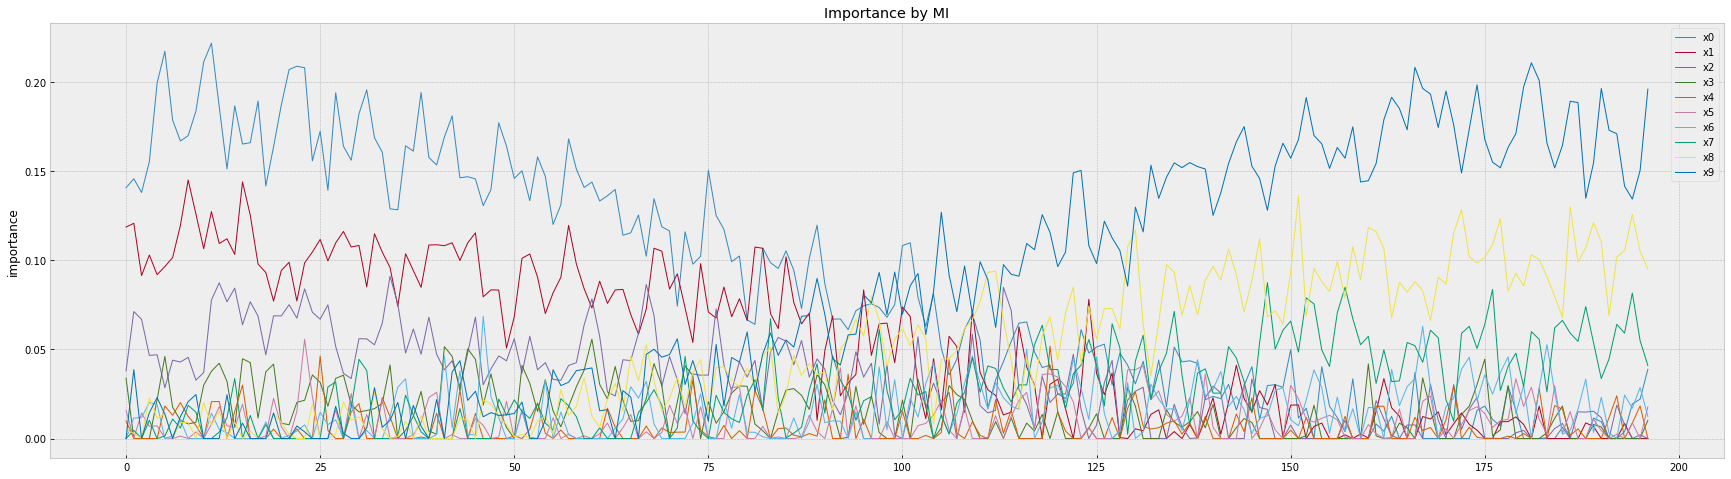

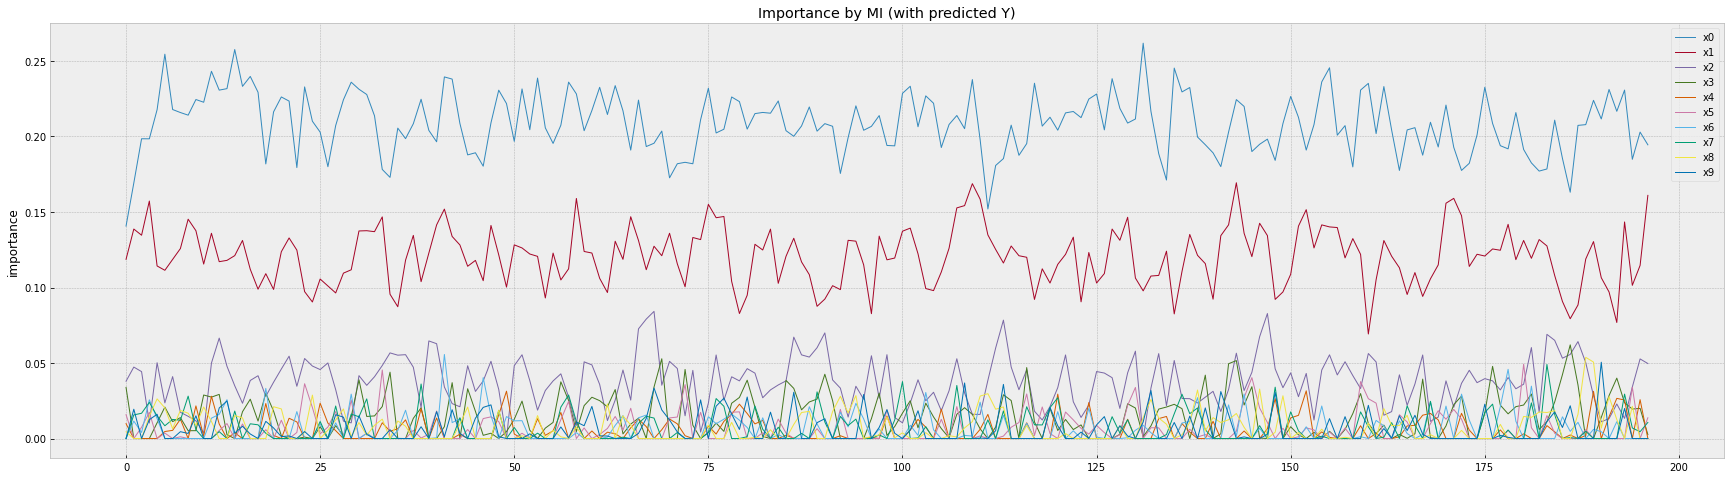

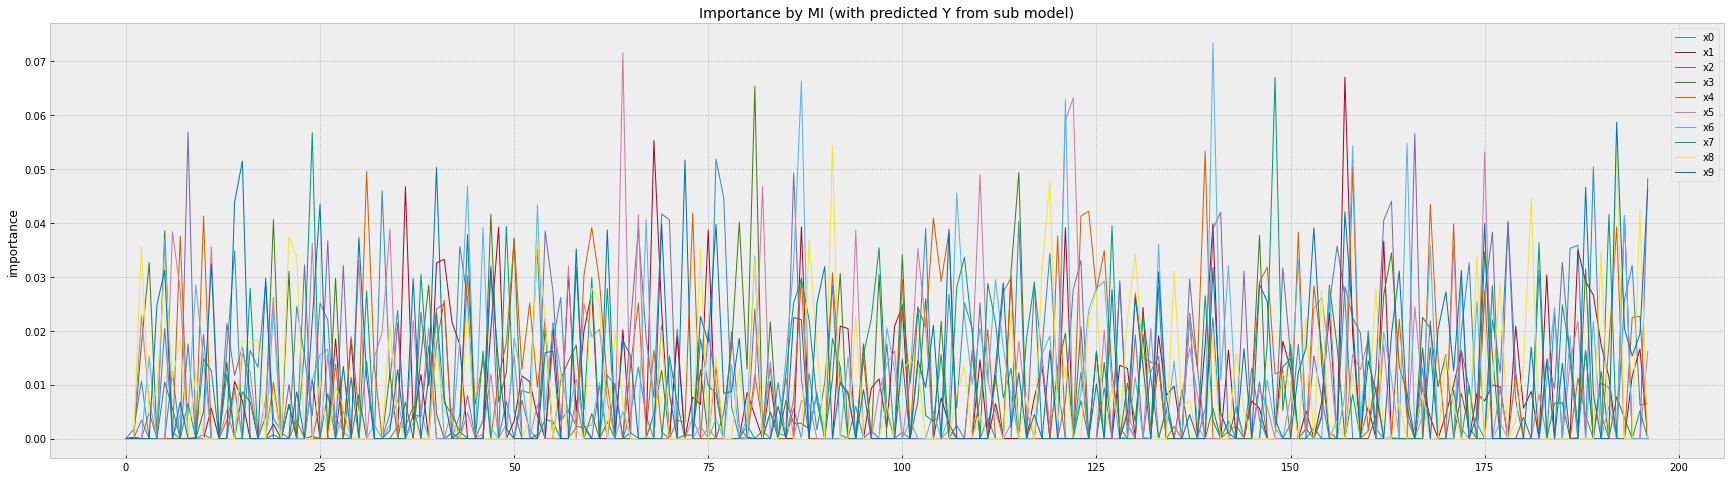

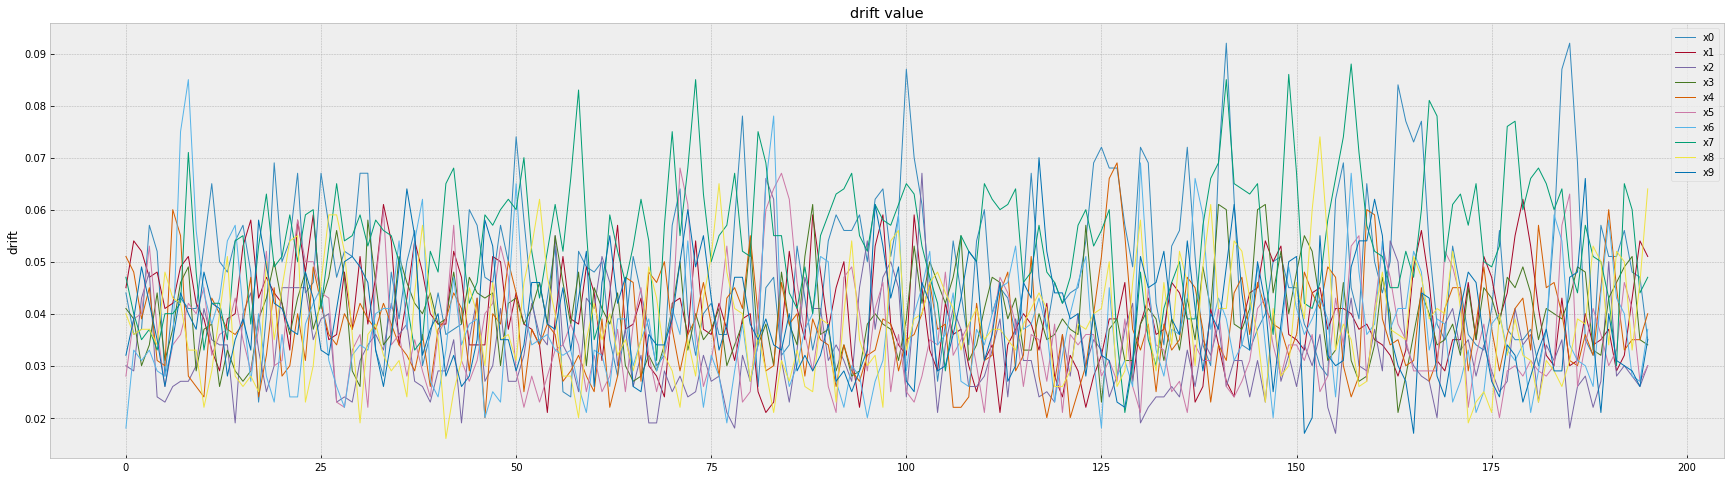

In [122]:
plt.style.use('bmh')

result_df = pd.DataFrame(result)
#result_df[['precision','sub_precision']].plot(ylabel='precision',linewidth=1,figsize=(30,8))
result_df['precision'].plot(ylabel='precision',linewidth=1,figsize=(30,8))

result_df[['y_-y__']].plot(ylabel='delta Y',linewidth=1,figsize=(30,8))


ax = imp_df_mi.plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

ax = imp_df_mi2.plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

ax = imp_df_mi3.plot(ylabel='importance',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("Importance by MI (with predicted Y from sub model)",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

tmp_df = pd.DataFrame(drifts)

ax = tmp_df.plot(ylabel='drift',linewidth=1,figsize=(30,8),legend=True)
ax.set_title("drift value",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [44]:
result_df

,precision,sub_precision,y_-y__,drift
0,0.872340,0.770291,inf,0.376
1,0.870968,0.788462,inf,0.393
2,0.887179,0.796407,inf,0.393
3,0.892473,0.797170,inf,0.433
4,0.893238,0.815873,inf,0.367
...,...,...,...,...
191,0.532258,0.543131,inf,0.388
192,0.515315,0.543614,inf,0.431
193,0.539931,0.571207,inf,0.396
194,0.540728,0.557300,inf,0.367


### 결론

importance가 변하는 concept drift는 PMI에서 변화를 감지 할 수 없다... 당연한거 아님!!!